# Data Scientist Associate Practical Exam Submission

Use this template to complete your analysis and write up your summary for submission.


In [3]:
pip install category_encoders

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for category_encoders from https://files.pythonhosted.org/packages/1f/e2/495811f12b2e90753fff0e42a07adb0370a725de17cc23a579ac9d3ca67c/category_encoders-2.6.2-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 21.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split
import category_encoders as ce
from sklearn.metrics import mean_squared_error as MSE

## Data Preview

In [5]:
enrollment_df = pd.read_csv(r'university_enrollment_2306.csv')

enrollment_df.head()

,course_id,course_type,year,enrollment_count,pre_score,post_score,pre_requirement,department
0,1,classroom,2018,165,28.14,73.0,Beginner,Science
1,2,classroom,2020,175,79.68,86.0,None,Science
2,3,online,2016,257,57.24,80.0,NaN,Mathematics
3,4,online,2013,251,97.67,75.0,Beginner,Technology
4,5,classroom,2019,165,39.75,76.0,Beginner,Science


## Task 1 
First let's identify each columns data type.

In [6]:
enrollment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1850 entries, 0 to 1849
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   course_id         1850 non-null   int64  
 1   course_type       1850 non-null   object 
 2   year              1850 non-null   int64  
 3   enrollment_count  1850 non-null   int64  
 4   pre_score         1850 non-null   object 
 5   post_score        1665 non-null   float64
 6   pre_requirement   1761 non-null   object 
 7   department        1850 non-null   object 
dtypes: float64(1), int64(3), object(4)
memory usage: 115.8+ KB


### Column Data Type verification:

* **course_id** - These are nominal values labeling their placement in the database. This column should technically be an object, This would be done by converting values into strings. However, course_id should have no relation to the target variable and will likely be removed. This is **incorrect**.
* **course_type** - Nominal values labeling whether the course is 'online' or 'classroom'. These should be object data types and are the correct datatype in our dataset.
* **year** - Listed as discrete in the provided table and are integer data type. This is correct.
* **enrollment_count** - Listed as discrete in the provided table and are integer data type. This is correct.
* **pre_score** - This column is the only one whose datatype is incorrect. It should be a float rather than an object. This is **incorrect**.
* **post_score** - This is listed as a continuous column and should be a float. This column is correct.
* **pre_requirement** - Nominal values labeling "None", "Beginner", "Intermediate". This column should be an object. This column is correct.
* **department** - Nominal values labeling "Science", "Technology", "Engineering", "Mathematics". This column should be an object. This is correct.

#### Correcting course_id

The assumption is this column has no relation to the number of enrolled students. My initial thought was that these values could follow a sequence throughout the year. Glancing at the Data Preview of the top 5 rows shows this assumption is incorrect. We will compare enrollment_count to course_id in a scatter plot to identify any correlation. If not then we will delete the column.

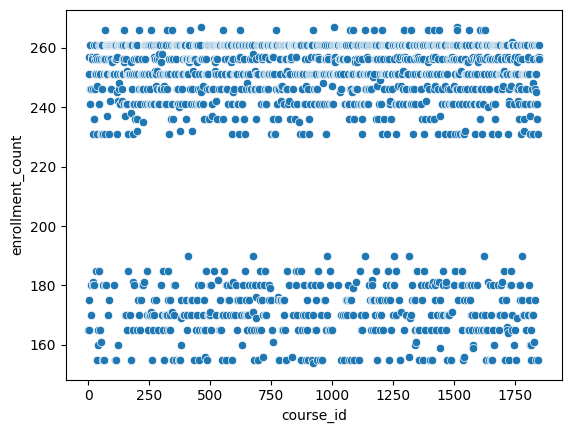

In [61]:
sns.scatterplot(data=enrollment_df, x='course_id', y='enrollment_count')
plt.show()

There appears to be no correlation between the two variables. However there are two distinct groups in the dataset. Column_id will be removed.

In [62]:
enrollment_df = enrollment_df.drop('course_id', axis=1)
print('course_id removed')

course_id removed


#### Correcting pre_score
 Before changing the value we will check if all values can convert to a float. This is achieved by pulling any values that cannot be converted into a float.

In [63]:
incorrect_values = []
for value in enrollment_df['pre_score']:
    try:
        float(value)
    except:
        if value not in incorrect_values:
            incorrect_values.append(value)
        
print("Non-numeric values found: ", incorrect_values)

Non-numeric values found:  ['-']


It appears there are values with a '-' in them. According to the instructions this can be replaced with 0. This is accomplished with Pandas '.replace'. Then we will convert the column data type to float using Pandas .to_numeric function.

In [64]:
enrollment_df['pre_score'].replace('-', 0, inplace=True)
enrollment_df['pre_score'] = pd.to_numeric(enrollment_df['pre_score'])
enrollment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1850 entries, 0 to 1849
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   course_type       1850 non-null   object 
 1   year              1850 non-null   int64  
 2   enrollment_count  1850 non-null   int64  
 3   pre_score         1850 non-null   float64
 4   post_score        1665 non-null   float64
 5   pre_requirement   1761 non-null   object 
 6   department        1850 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 101.3+ KB


### Missing Values:

Judging from .info results there are 2 columns with missing values; post_score and pre_requirement. Before fixing them I want to double check other columns to be certain their values are consistent. 

#### Verify Numeric Features
First, I used .describe to get some general statistics of the numeric columns. All but post_score looked good. 

In [65]:
enrollment_df.describe()

,year,enrollment_count,pre_score,post_score
count,1850.000000,1850.000000,1850.000000,1665.000000
mean,2016.423784,231.565405,46.047022,75.204805
std,3.448278,36.987029,30.555461,8.511981
min,2011.000000,154.000000,0.000000,51.000000
25%,2013.000000,185.000000,18.447500,69.000000
50%,2016.000000,251.000000,45.450000,75.000000
75%,2019.000000,261.000000,72.525000,81.000000
max,2022.000000,267.000000,100.000000,105.000000


#### Verify Categorical Features
Then I looked at the categorical columns to find whether categorical values matched the provided table. This was accomplished by extracting categorical column names from the dataframe the looping through them and printing their value_counts. In the end all categories looked good except for pre_requirement which we already knew had missing values.

In [66]:
categorical_columns = list(enrollment_df.select_dtypes(include=['object']).columns)

for col in categorical_columns:
    print(col)
    print(enrollment_df[col].value_counts(), '\n')

course_type
online       1375
classroom     475
Name: course_type, dtype: int64 

pre_requirement
None            802
Beginner        654
Intermediate    305
Name: pre_requirement, dtype: int64 

department
Technology     719
Science        472
Mathematics    220
Math           220
Engineering    219
Name: department, dtype: int64 



#### Correcting Missing Values
To fix the missing values I used Panda's .fillna. For post_score NA values were replaced with 0 and pre_requirement NA values were replaced with 'None'. Once completed I double checked the Non-Null value counts were the same using .info.

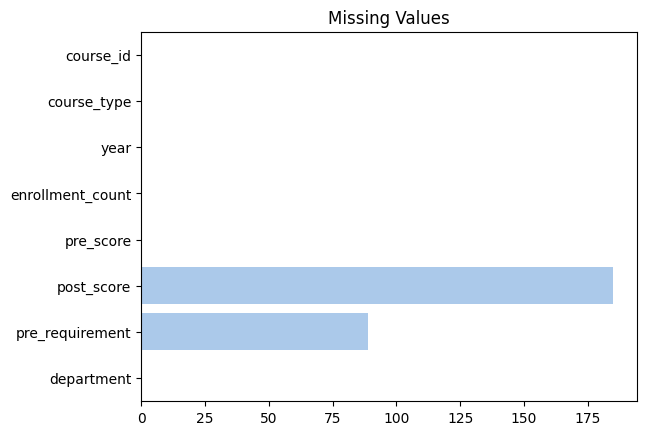

In [18]:
missing_value_counts = []
columns = enrollment_df.columns.values

for col in enrollment_df.columns:
    missing_value_counts.append(enrollment_df[col].isna().sum())

sns.barplot(x=missing_value_counts, y=columns, color='b').set(title="Missing Values")
plt.show()

In [67]:
enrollment_df['post_score'].fillna(0, inplace=True)
enrollment_df['pre_requirement'].fillna('None', inplace=True)

enrollment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1850 entries, 0 to 1849
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   course_type       1850 non-null   object 
 1   year              1850 non-null   int64  
 2   enrollment_count  1850 non-null   int64  
 3   pre_score         1850 non-null   float64
 4   post_score        1850 non-null   float64
 5   pre_requirement   1850 non-null   object 
 6   department        1850 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 101.3+ KB


## Task 2
Below is a visual depicting the distribution of enrollment_counts

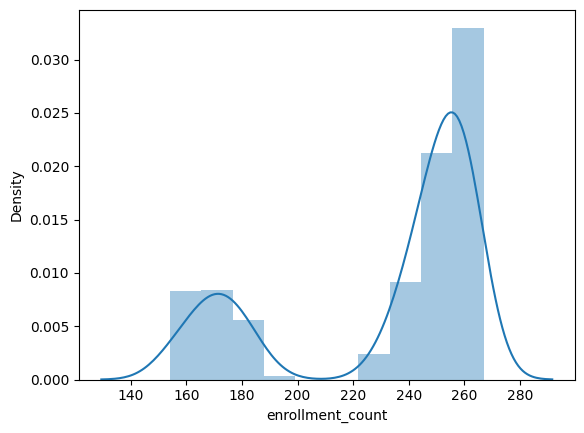

In [68]:
sns.distplot(a=enrollment_df['enrollment_count'])
plt.show()

This is a bimodal distribution, meaning it has two peaks. This suggests there two processes involved in this dataset. It is very likely these are distributed by the course_type. Below, I will create a histogram using enrollment_count as the x-axis and adding course type as the hue.

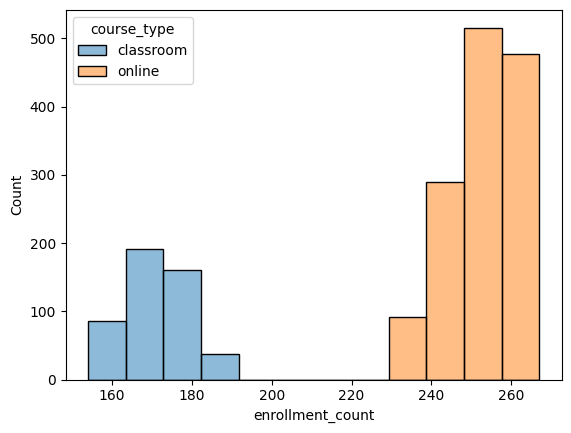

In [69]:
sns.histplot(data=enrollment_df, x='enrollment_count', hue='course_type')

plt.show()

The results are as predicted. The bimodal nature of our distribution is split up into 'classroom' and 'online'. Given the limit on classroom sizes it makes sense that 'online' sould have a higher enrollment count.

## Task 3
Below is a plot of the number of observations per course type. Based on the barplot the online class have the greatest number of observations. The observations are not balanced and 'online' appears to have three times as many observations as 'classroom'. This could be caused by the number of classes offered.

<AxesSubplot: >

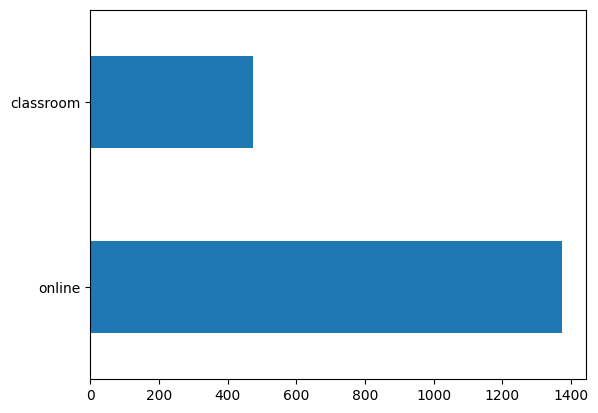

In [70]:
enrollment_df['course_type'].value_counts().plot(kind='barh')

In [75]:
enrollment_df.groupby(['course_type','department','pre_requirement'])['department'].count()

course_type  department   pre_requirement
classroom    Engineering  Beginner            51
                          Intermediate        66
                          None                 8
             Math         Beginner            20
                          Intermediate         6
                          None                16
             Mathematics  Beginner            17
                          Intermediate        10
                          None                21
             Science      Beginner            70
                          Intermediate        70
                          None                38
             Technology   Beginner            34
                          Intermediate        19
                          None                29
online       Engineering  Beginner            41
                          Intermediate        23
                          None                30
             Math         Beginner            66
                          I

## Task 4
Course type has a distinct relationship with enrollment counts. The scatter plot below shows classrooms with enrollment counts between 100 and 200 while online is between 220 and 280 enrollment counts. If we wanted to build a model predicting the course type based on enrollment counts this could easily be created using logistic regression. 

I also wanted to see if enrollment increased year by year however, the enrollment count tends to remain within specific values. Based on the plot online also tends to have less variation in enrollment counts while classroom has more variation. Maybe this is cause by enrollment requirements for each type.

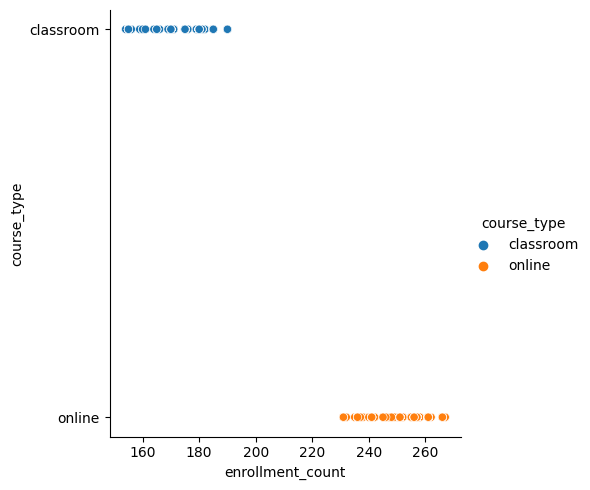

In [46]:
sns.relplot(data=enrollment_df, x= 'enrollment_count', y='course_type', hue='course_type')
plt.show()

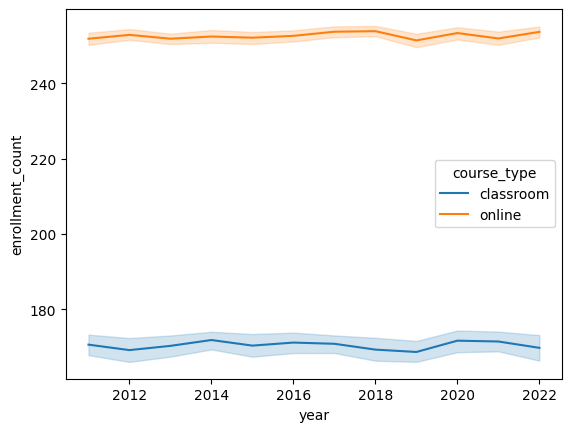

In [47]:
sns.lineplot(data=enrollment_df, x='year', y='enrollment_count', hue='course_type')
plt.show()

## Task 5
To predict the number of student enrolled in a course we will need to use a regression model. Regression predicts a continuous quantity. Since we need to predict future enrollments regression is the best option.

## Task 6
The first model data will be fit to is call Extreme Gradient Boosing (XGBoost). Specifically the regression version.

Before fitting the model we need to convert categorical data to numerical so our models can work properly.

Then data needs to be split into three groups; Train, Test, validation. 

Validation is separated first with 20% of the data and the train_test dataset will contain 80% of the data.


In [48]:
# encode categorical columns
for col in categorical_columns:
    # categorical data transformer
    ce_be = ce.BinaryEncoder(cols=col)
    
    # fit dataframe
    enrollment_df_cat = ce_be.fit_transform(enrollment_df[col])
    
    enrollment_df = pd.concat([enrollment_df, enrollment_df_cat], axis='columns')
    
enrollment_df = enrollment_df.drop(categorical_columns, axis=1)

# split into validation and train_test dataset
validation = enrollment_df[enrollment_df['year'] == 2022].reset_index()
train_test = enrollment_df[enrollment_df['year'] != 2022].reset_index()

# separate validation set into dependent and independent features
X_val = validation.drop('enrollment_count', axis=1)
y_val = validation['enrollment_count']

# create X y datasets
X = train_test.drop('enrollment_count', axis=1)
y = train_test['enrollment_count']


###############
# Model Fitting
###############
kfold = KFold(n_splits=10, random_state=24, shuffle=True)

scores = []

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]
    
    xgb_r = xgb.XGBRegressor(n_estimators=30, seed=24)
    
    # fit model
    xgb_r.fit(X_train, y_train)
    preds = xgb_r.predict(X_test)
    
    score = MSE(y_test, preds)**.5
    scores.append(score)
    
average_rmse = np.mean(scores)

print(f'RMSE of each fold: {scores}')
print(f'Mean of RMSE scores: {average_rmse}')

RMSE of each fold: [0.34680038295250354, 0.4809878751809129, 0.3638467847645277, 0.2696745267671127, 0.38182614074522264, 0.36317440770948256, 0.34895673921899245, 0.39304756472360136, 0.37865876217928596, 0.49476219335525473]
Mean of RMSE scores: 0.38217353775968965


## Task 7
The second model is Decision Tree Regression.

In [49]:
###############
# Model Fitting
###############
kfold = KFold(n_splits=10, random_state=24, shuffle=True)

scores = []

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]
    
    dt_r = DecisionTreeRegressor(max_depth=11)
    
    # fit model
    dt_r.fit(X_train, y_train)
    preds = dt_r.predict(X_test)
    
    score = MSE(y_test, preds)**.5
    scores.append(score)
    
average_rmse = np.mean(scores)

print(f'RMSE of each fold: {scores}')
print(f'Mean of RMSE scores: {average_rmse}')

RMSE of each fold: [0.43491951498864123, 0.48743993556658627, 0.414457931299901, 0.4220611053053035, 0.46493677761586694, 0.5384160716928141, 0.4859733698410088, 0.47001308460611224, 0.4607779771536007, 0.5458894101637971]
Mean of RMSE scores: 0.4724885178233632


## Task 8
Both XGBoost and Decision Tree  seems like the best options. Both are flexible and capable of producing results from multiple features. XGBoost is a bit more robust then the decision tree in that it tests the model on multiple algorithms. For larger projects it might be more resource intensive than the decision tree. The decision tree can be faster than XGBoost in larger projects. I chose these two to see how they compared in this test set. 

## Task 9
To evaluate the results I applied the 2022 validation dataset to the models. Both models performed very well but Decision Tree had the smallest Root Mean Squared Error RMSE (0.481), XGBoost has a score of 0.509. 

In [50]:
xgb_preds = xgb_r.predict(X_val)

RMSE = MSE(y_val, xgb_preds)**.5
print(RMSE)

0.5092635905230457


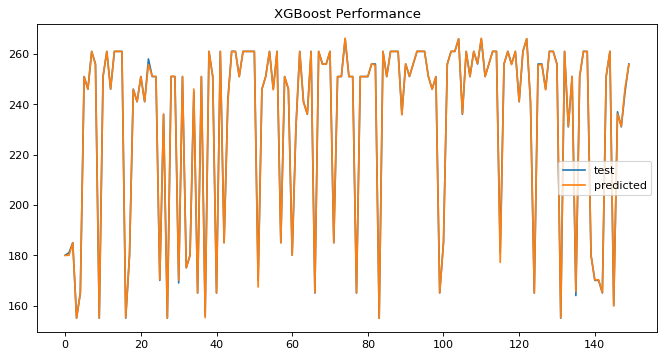

In [51]:
plt.figure(figsize=(10, 5), dpi=80)
x_ax = range(len(y_val))
plt.plot(x_ax, y_val, label="test")
plt.plot(x_ax, xgb_preds, label="predicted")
plt.title('XGBoost Performance')
plt.legend()
plt.show()

In [52]:
dt_preds = dt_r.predict(X_val)

RMSE = MSE(y_val, dt_preds)**.5
print(RMSE)

0.4696470970409772


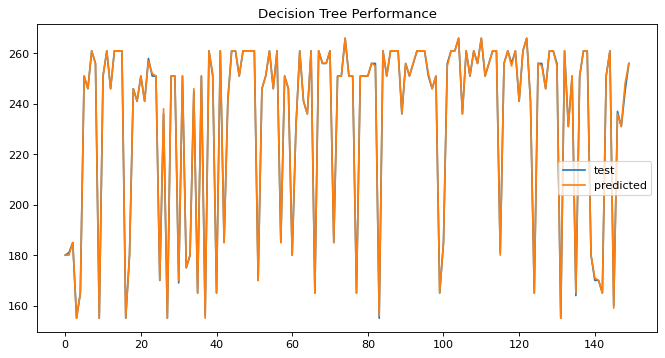

In [53]:
plt.figure(figsize=(10, 5), dpi=80)
x_ax = range(len(y_val))
plt.plot(x_ax, y_val, label="test")
plt.plot(x_ax, dt_preds, label="predicted")
plt.title('Decision Tree Performance')
plt.legend()
plt.show()

## Task 10
When evaluating both models they were evaluated with values from 2022. Testing both models resulted in XGBoost out performing Decision Tree. Decision tree likely outperformed XGBoost in the validation set because XGBoost overfits the data in testing making it hard for it to predict new values. 

In conclusion, the decision tree model is the best option to predict student attendance. It's more flexible than XGBoost making it better suited to predicting student enrollment. Through EDA we have determined that Online enrollment is significantly higher than classroom enrollments. Therefore the course type has a definitive contribution to the number of enrolled students.